In [1]:
2 + 2

4

In [2]:
import os
import sys

# Libraries for data processing and manipluation
import math
import numpy as np
import pandas as pd

# Libraries for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for inference and type hinting
from typing import Tuple, List, Union

# Libraries for feature encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Libraries for statistical testing
import scipy.stats as stats
from scipy.stats import probplot
from scipy.stats import normaltest
from scipy.stats import shapiro

In [3]:
# Data cleaning methods

def duplicate_remover(df:pd.DataFrame, original_df: pd.DataFrame) -> None:
    """Function to remove any duplicate rows (if any)

    Args:
        df (pd.DataFrame): Pandas dataframe
        original_df (pd.DataFrame): Original pandas dataframe
    """
    rs, cs = original_df.shape

    df.drop_duplicates(inplace=True)

    if df.shape == (rs,cs):
        print("The dataset doesn't have any duplicates")
    else:
        print(f"Number of duplicates dropped/fixed ---> {rs - df.shape[0]}")

def convert_object_to_numeric(df: pd.DataFrame, column_list: List[str]) -> None:
    """Function to convert specified columns from object type to numeric

    Args:
        df (pd.DataFrame): Pandas dataframe
        column_list (List[str]): _description_
    """
    for column in column_list:
        df[column] = pd.to_numeric(df[column])


def check_empty_elements(df:pd.DataFrame) -> pd.DataFrame:
    """Function to check for empty elements in the dataframe

    Args:
        df (pd.DataFrame): Pandas dataframe

    Returns:
        pd.DataFrame: _description_
    """
    null_value_counts = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
    null_value_counts['Percentage'] = round(null_value_counts['Total Null Values']/df.shape[0],3)*100
    return null_value_counts

def remove_outliers(df: pd.DataFrame, features: List[str], target:str) -> None:
    """Removal of outliers from given dataframe

    Args:
        df (pd.DataFrame): Pandas dataframe
    """
    before_removal_shape = df.shape
    numerical_features = categorical_numerical_features_split(df, features=features, target=target, single_feature='numerical')

    for i in numerical_features:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        df = df[df[i] <= (Q3+(1.5*IQR))]
        df = df[df[i] >= (Q1-(1.5*IQR))]
        df = df.reset_index(drop=True)

    after_removal_shape = df.shape

    percentage_drop = (before_removal_shape[0] - after_removal_shape[0]) * 100 / before_removal_shape[0]

    print('Before removal of outliers, The dataset had {} samples.'.format(before_removal_shape[0]))
    print('After removal of outliers, The dataset now has {} samples.'.format(after_removal_shape[0]))
    print(f"{round(percentage_drop, 2)}% drop")

In [4]:
# Data preparation methods

def features_target_split(df: pd.DataFrame, target: str) -> Union[Tuple[str, List[str]], None]:
    """Split the DataFrame into feature columns and target column.

    Args:
        df (pd.DataFrame): Pandas dataframe
        target (str): _description_

    Returns:
        Union[Tuple[str, List[str]], None]: _description_
    """
    if target in df.columns:
        features = [i for i in df.columns if i not in [target]]
        print('The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))
        return features, target
    else:
        f"Wrong Column name: {target}. Please select the right column from the following: {df.columns}"
        return None
    
def encode_categorical_data(df: pd.DataFrame, features: List[str], target: str) -> None:
    """Function to convert categorical columns to numeric columns through One-Hot or Dummy Encoding

    Args:
        df (pd.DataFrame): Pandas dataframe
    """
    categorical_features = categorical_numerical_features_split(df=df, features=features, target=target, single_feature='categorical')
    null_value_counts = check_empty_elements(df=df)

    empty_column_count = null_value_counts[null_value_counts['Percentage'] != 0].index.values

    filtered_categorical_columns = []
    for i in categorical_features:
        if i not in empty_column_count:
            filtered_categorical_columns.append(i)

    # filtered_categorical_columns = [i for i in categorical_features if i not in empty_column_count]

    #One-Hot or Dummy Encoding
    for i in filtered_categorical_columns:
        if df[i].nunique() == 2:
            print(f"One-Hot Encoding on feature: {i}")
            df[i] = pd.get_dummies(df[i], drop_first=True, prefix=str(i))

        elif (2 < df[i].nunique() < 17):
            print(f"Dummy Encoding on features: {i}")
            df = pd.concat([df.drop([i], axis = 1), pd.DataFrame(pd.get_dummies(df[i], drop_first = True, prefix = str(i)))], axis = 1)
            
    print(f"df shape: {df.shape}")


def preprocessed_dataset(df:pd.DataFrame, original_df: pd.DataFrame) -> None:
    """Plot the final Dataset size after performing Preprocessing

    Args:
        df (pd.DataFrame): Pandas dataframe
        original_df (pd.DataFrame): _description_
    """

    df.columns = [i.replace('-','_') for i in df.columns]
    
    dropped_samples_num = original_df.shape[0] - df.shape[0]

    plt.title('Final Dataset')
    plt.pie([df.shape[0], dropped_samples_num], radius = 1, labels=['Retained','Dropped'], counterclock=False,
            autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
    plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
    plt.show()

    print(f'After the cleanup process, {dropped_samples_num} samples were dropped, while retaining {round((df.shape[0] * 100 / (original_df.shape[0])),2)}% of the data.')
    
def encode_columns(df: pd.DataFrame, target: str, ordinal_cols: List[str]=None, nominal_cols: List[str]=None) -> None:
    """_summary_

    Args:
        df (pd.DataFrame): Pandas dataframe
        target (str): Target column name
        ordinal_cols (List[str], optional): _description_. Defaults to None.
        nominal_cols (List[str], optional): _description_. Defaults to None.
    """

    if ordinal_cols is None:
        ordinal_cols = []
    if nominal_cols is None:
        nominal_cols = []

    if not ordinal_cols and not nominal_cols:
        ordinal_cols, nominal_cols = determine_encoding(df=df)

    numerical_cols = [col for col in df.columns if df[col].dtype != 'object' and col not in nominal_cols and col not in ordinal_cols]
    transformers = [('numerical', 'passthrough', numerical_cols)]

    if ordinal_cols:
        transformers.append(('ordinal', OneHotEncoder(categories='auto'), ordinal_cols))

    if nominal_cols:
        transformers.append(('nominal', OneHotEncoder(), nominal_cols))

    transformers.append(('target', 'passthrough', target))

    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Fit and transform the data
    transformed_data = preprocessor.fit_transform(df)

    # Get the column names after transformation
    column_names = preprocessor.get_feature_names_out()

    df = pd.DataFrame(transformed_data, columns=column_names)

In [5]:
# Feature engineering methods

def categorical_numerical_features_split(df: pd.DataFrame, features: List[str], target: str, single_feature: str=None) -> Union[Tuple[List[str], List[str]], None]:
    """Function to check the number of unique rows in each feature of the dataframe

    Args:
        df (pd.DataFrame): Pandas dataframe

    Returns:
        Union[List[str], List[str]]: _description_
    """

    unique_values_num = df[features].nunique().sort_values()
    numerical_features = []
    categorial_features = []

    for i in range(df[features].shape[1]):
        if unique_values_num.values[i] <= 16:
            categorial_features.append(unique_values_num.index[i])
        else:
            numerical_features.append(unique_values_num.index[i])

    print(f'The Dataset has {len(numerical_features)} numerical & {len(categorial_features)} categorical features.')
    

    if single_feature is not None:
        if single_feature == 'numerical':
            return numerical_features
        elif single_feature == 'categorical':
            return categorial_features
        else:
            print("Wrong feature name selected. Please selected between 'numerical' and 'categorical")
            return None
    else:
        return numerical_features, categorial_features
    
def determine_encoding(df: pd.DataFrame, unique_val_threshold: int=10, return_ordinal_only=False, return_nominal_only=False) -> Union[Tuple[List[str], List[str]], List[str]]:
    """_summary_

    Args:
        df (pd.DataFrame): Pandas dataframe
        unique_val_threshold (int, optional): _description_. Defaults to 10.
        return_ordinal_only (bool, optional): _description_. Defaults to False.
        return_nominal_only (bool, optional): _description_. Defaults to False.

    Returns:
        Union[Tuple[List[str], List[str]], List[str]]: _description_
    """
    ordinal_cols = []
    nominal_cols = []
    
    # Inspect each column
    for column in df.columns:
        # Check if the column is categorical
        if df[column].dtype == 'object' or df[column].nunique() <= unique_val_threshold:
            # Check if the column should be encoded using One-Hot (ordinal) encoding
            if df[column].nunique() == 2:
                ordinal_cols.append(column)
            # Check if the column should be encoded using Dummy (nominal) encoding
            elif df[column].nunique() > 2:
                nominal_cols.append(column)
    
    if return_ordinal_only:
        return ordinal_cols
    elif return_nominal_only:
        return nominal_cols
    else:
        return ordinal_cols, nominal_cols

In [6]:
# Exploratory Data Analysis (EDA) methods

def target_feature_visualizer(df: pd.DataFrame, target_column_name: str) -> None:
    """Function to plot the distribution of the target variable

    Args:
        df (pd.DataFrame): Pandas dataframe
        target_column_name (str): _description_
    """

    plt.figure(figsize=[8,4])
    sns.distplot(df[target_column_name], color='g', hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
    plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
    plt.grid(True)
    plt.show()

    print("The target variable seems to follow a normal distribution curve, averaging at around 20 units")

def categorical_features_visualizer(df: pd.DataFrame, features: List[str], target:str) -> None:
    """Function to visualize the categorical features of the dataframe

    Args:
        df (pd.DataFrame): Pandas dataframe

    Note: Function breaks down with current dataset. Needs encoding before being executed. Error: ValueError: could not convert string to float: 'yes'
    """
    print('Visualising Categorical Features:')
    categorial_features = categorical_numerical_features_split(df=df, features=features, target=target, single_feature='numerical')

    n = 3
    plt.figure(figsize=[15, 3 * math.ceil(len(categorial_features) / n)])

    for i in range(len(categorial_features)):
        if df[categorial_features[i]].nunique() <= 8:
            plt.subplot(math.ceil(len(categorial_features) / n), n, i + 1)
            sns.countplot(df[categorial_features[i]])
        else:
            plt.subplot(3, 1, 3)
            sns.countplot(df[categorial_features[i]])
            
    plt.tight_layout()
    plt.show()

def numerical_features_visualizer(df: pd.DataFrame, features: List[str], target:str, method='distribution') -> None:
    """Function to visualize the numeric features of the dataframe

    Args:
        df (pd.DataFrame): Pandas dataframe
        method (str, optional): _description_. Defaults to 'distribution'.
    """

    if method == "distribution":
        print('Numerical Features Distribution')
    elif method == "boxplot":
        print('Numerical Features Boxplot')
    else:
        print("Wrong plot selected. Please selected between 'distribution' and 'boxplot")
        return None

    n=3

    numerical_features = categorical_numerical_features_split(df=df, features=features, target=target, single_feature='numerical')

    plt.figure(figsize=[15,3*math.ceil(len(numerical_features)/n)])
    for i in range(len(numerical_features)):
        plt.subplot(math.ceil(len(numerical_features)/3),n,i+1)

        if method == "distribution":
            sns.distplot(df[numerical_features[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
            # Displot will be deprecated soon. Switch with up-to-date function
        else:
            df.boxplot(numerical_features[i])

    plt.tight_layout()
    plt.show()

In [7]:
# Data validation methods

def check_encoding(df: pd.DataFrame, column: str) -> str:
    """
    Check if a categorical variable has been encoded with either dummy or one-hot encoding.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the categorical variable.
    - column (str): The name of the categorical column to check.
    
    Returns:
    - str: The type of encoding applied ('One-Hot Encoding', 'Dummy Encoding', or 'Not Encoded').
    """
    if column not in df.columns:
        return f'Column: {column} not found'
    
    unique_values = df[column].unique()
    if len(unique_values) == 2 and set(unique_values) == {0, 1}:
        return f"Column '{column}' encoded with One-Hot Encoding"
    elif len(unique_values) > 2:
        return f"Column '{column}' encoded with Dummy Encoding"
    else:
        return f"Column '{column}' not encoded"

def get_num_unique_values(df: pd.DataFrame, column_name: str) -> int:
    """Function to get the number of unique values in a given column of a given dataframe

    Args:
        df (pd.DataFrame): Pandas dataframe
        column_name (str): Name of a column, which is a part of the pandas dataframe

    Returns:
        int: Total number of unique values, as an integer
    """
    return df[column_name].nunique()

In [8]:
# Normal Distribution testing methods

def shapiro_wilk_test(df: pd.DataFrame, target: str) -> None:
    """The Shapiro-Wilk test for normality.

    Args:
        df (pd.DataFrame): Pandas dataframe
        target (str): Target column name
    """
    stat, p = shapiro(df[target])
    print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

def d_agostino_ktwo_test(df: pd.DataFrame, target: str) -> None:
    """The D'Agostino's K^2 test for normality.

    Args:
        df (pd.DataFrame): Pandas dataframe
        target (str): Target column name
    """
    stat, p = normaltest(df[target])
    print('D\'Agostino\'s K^2 Test: Statistics=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

def probability_plot(df: pd.DataFrame, target: str) -> None:
    """_summary_

    Args:
        df (pd.DataFrame): Pandas dataframe
        target (str): Target column name
    """
    probplot(df[target], dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.grid(True)
    plt.show()

def data_skewness(df: pd.DataFrame, target: str) -> None:
    skew_value = df[target].skew()
    if skew_value > 1:
        print(f"Positively highly skewed target data (> +1): {skew_value}")
    else:
        print(f"Negatively highly skewed target data (< -1): {skew_value}")

In [9]:
TARGET_COLUMN_NAME = 'price'

dataset_dir = os.path.join(os.getcwd(), 'housing-prices-dataset')
housing_csv_file = os.path.join(dataset_dir, 'housing.csv')
df = pd.read_csv(housing_csv_file)
original_df = df.copy(deep=True)

df.head()
df.describe()

target = 'price'
features = [i for i in df.columns if i not in [target]]

In [11]:
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


In [13]:
features, target = features_target_split(df=df, target=TARGET_COLUMN_NAME)

The Datset consists of 13 features & 545 samples.


In [14]:
numerical_features, categorial_features = categorical_numerical_features_split(df=df, features=features, target=target)

The Dataset has 1 numerical & 11 categorical features.


In [ ]:
shapiro_wilk_test(df=df, target=TARGET_COLUMN_NAME)

In [ ]:
d_agostino_ktwo_test(df=df, target=TARGET_COLUMN_NAME)

In [ ]:
data_skewness(df=df, target=TARGET_COLUMN_NAME)

In [ ]:
probability_plot(df=df, target=TARGET_COLUMN_NAME)

c:\Users\User\miniconda3\envs\programming\lib\site-packages\ipykernel_launcher.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if sys.path[0] == "":


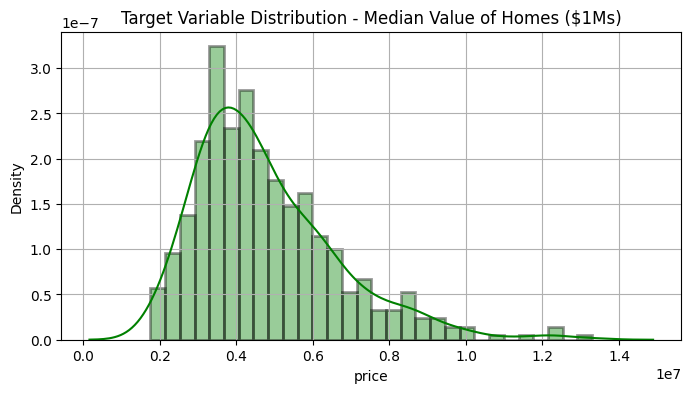

The target variable seems to follow a normal distribution curve, averaging at around 20 units


In [15]:
target_feature_visualizer(df=df, target_column_name=TARGET_COLUMN_NAME)

Visualising Categorical Features:
The Dataset has 1 numerical & 11 categorical features.


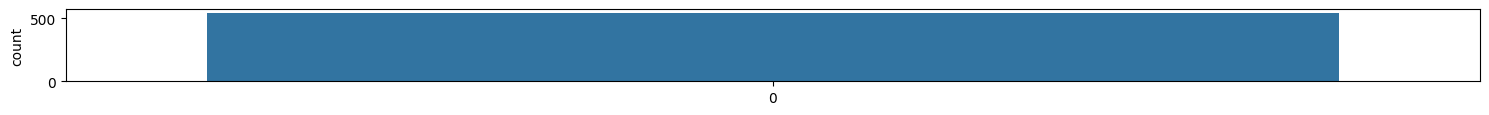

In [16]:
categorical_features_visualizer(df=df, features=features, target=target)

Numerical Features Distribution
The Dataset has 1 numerical & 11 categorical features.


c:\Users\User\miniconda3\envs\programming\lib\site-packages\ipykernel_launcher.py:69: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



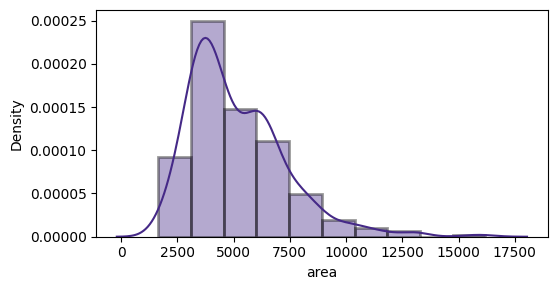

In [17]:
numerical_features_visualizer(df=df, features=features, target=target, method='distribution')

In [18]:
duplicate_remover(df=df, original_df=original_df)

The dataset doesn't have any duplicates


In [19]:
null_value_counts = check_empty_elements(df=df)

In [20]:
encode_categorical_data(df=df, features=features, target=target)

The Dataset has 1 numerical & 11 categorical features.
One-Hot Encoding on feature: mainroad
One-Hot Encoding on feature: guestroom
One-Hot Encoding on feature: basement
One-Hot Encoding on feature: hotwaterheating
One-Hot Encoding on feature: airconditioning
One-Hot Encoding on feature: prefarea
Dummy Encoding on features: furnishingstatus
Dummy Encoding on features: bathrooms
Dummy Encoding on features: stories
Dummy Encoding on features: parking
Dummy Encoding on features: bedrooms
df shape: (545, 24)


In [21]:
for column in df.columns:
    print(check_encoding(df=df, column=column))

Column 'price' encoded with Dummy Encoding
Column 'area' encoded with Dummy Encoding
Column 'bedrooms' encoded with Dummy Encoding
Column 'bathrooms' encoded with Dummy Encoding
Column 'stories' encoded with Dummy Encoding
Column 'mainroad' encoded with One-Hot Encoding
Column 'guestroom' encoded with One-Hot Encoding
Column 'basement' encoded with One-Hot Encoding
Column 'hotwaterheating' encoded with One-Hot Encoding
Column 'airconditioning' encoded with One-Hot Encoding
Column 'parking' encoded with Dummy Encoding
Column 'prefarea' encoded with One-Hot Encoding
Column 'furnishingstatus' encoded with Dummy Encoding


In [22]:
remove_outliers(df=df, features=features, target=target)

The Dataset has 1 numerical & 11 categorical features.
Before removal of outliers, The dataset had 545 samples.
After removal of outliers, The dataset now has 533 samples.
2.2% drop


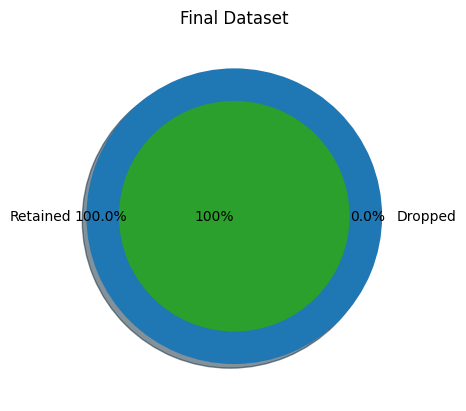

After the cleanup process, 0 samples were dropped, while retaining 100.0% of the data.


In [23]:
preprocessed_dataset(df=df, original_df=original_df)